In [1]:
!pip install -q efficientnet

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

import cv2
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.layers import Dense, Dropout
from efficientnet.tfkeras import EfficientNetB4

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [3]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path('shopee-product-detection-open')

# Configuration
EPOCHS = 30
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [5]:
train_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/train.csv')
test_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/test.csv')

train_df.shape, test_df.shape

((105390, 2), (12186, 2))

In [6]:
train_df.head()

filename  category
0  45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg         3
1  f74d1a5fc2498bbbfa045c74e3cc333e.jpg         3
2  f6c172096818c5fab10ecae722840798.jpg         3
3  251ffd610399ac00fea7709c642676ee.jpg         3
4  73c7328b8eda399199fdedec6e4badaf.jpg         3

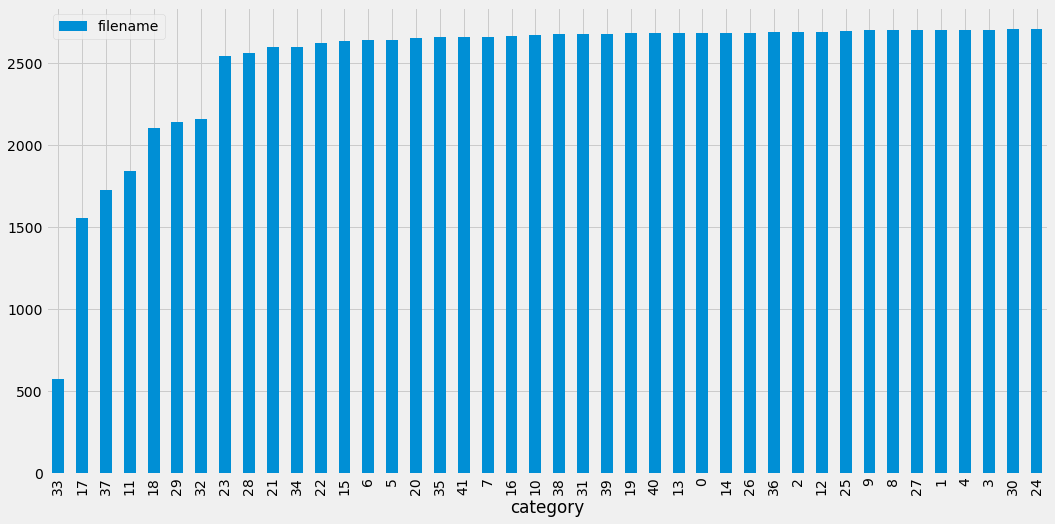

In [7]:
train_df.groupby('category').count().sort_values(by='filename').plot.bar()

# Create Dataset

In [8]:
# pick random samples

dataset_path = {}

categories = np.sort(train_df['category'].unique())

for cat in categories:
    dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(frac=1.)

In [9]:
category_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                 '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                 '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
                 '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41']

In [10]:
train_paths = []

for idx, key in enumerate(dataset_path.keys()):
    if key == idx:
        for path in dataset_path[idx]:
            train_paths.append(os.path.join(GCS_DS_PATH, 'train', 'train', 'train', category_list[idx], path))

In [11]:
labels = []

for label in dataset_path.keys():
    labels.extend([label] * len(dataset_path[label]))

In [12]:
from tensorflow.keras.utils import to_categorical

# convert to numpy array
ori_train_paths = np.array(train_paths)

# convert to one-hot-encoding-labels
ori_train_labels = to_categorical(labels)

In [13]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
indices = skf.split(ori_train_paths, labels)
k_fold = 0
i = 0
for train_index, test_index in indices:
    train_paths, valid_paths = ori_train_paths[train_index], ori_train_paths[test_index]
    train_labels, valid_labels = ori_train_labels[train_index], ori_train_labels[test_index]
    if i==k_fold:
        break
    else:
        i+=1

train_paths.shape, valid_paths.shape, train_labels.shape, valid_labels.shape

((84312,), (21078,), (84312, 42), (21078, 42))

In [14]:
test_paths = []

for path in test_df['filename']:
    test_paths.append(os.path.join(GCS_DS_PATH,  'test', 'test', 'test', path))
    
test_paths = np.array(test_paths)

# Augmentation

In [15]:
def decode_image(filename, label=None, image_size=(380, 380)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

In [16]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    
    if label is None:
        return image
    else:
        return image, label

In [17]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)   
    .map(data_augment, num_parallel_calls=AUTO)         
    .cache()
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

# First Round

In [18]:
%%time

with strategy.scope():
    model = tf.keras.Sequential([
        EfficientNetB4(weights='noisy-student',
                       include_top=False,
                       pooling='avg'),
        Dense(1024, activation='relu'),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dropout(0.2),        
        Dense(42, activation='softmax'),
        
    ])
    
    model.layers[0].trainable = False
    
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3,weight_decay=1e-4)
    model.compile(optimizer=optimizer,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
    
    model.summary()

71680000/71678424 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 1024)              1836032   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 42)                21546     
Total params: 20,056,194
Trainable params: 2,382,378
Non-

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, mode='min', restore_best_weights=True)

In [20]:
n_steps = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/30
658/658 [==============================] - 2584s 4s/step - accuracy: 0.5893 - loss: 1.7953 - val_accuracy: 0.1924 - val_loss: 5.8461 - lr: 0.0010
Epoch 2/30
658/658 [==============================] - 112s 170ms/step - accuracy: 0.7735 - loss: 0.7969 - val_accuracy: 0.2709 - val_loss: 5.2673 - lr: 0.0010
Epoch 3/30
658/658 [==============================] - 111s 168ms/step - accuracy: 0.8022 - loss: 0.6628 - val_accuracy: 0.2784 - val_loss: 4.4298 - lr: 0.0010
Epoch 4/30
658/658 [==============================] - 111s 169ms/step - accuracy: 0.8182 - loss: 0.6087 - val_accuracy: 0.3000 - val_loss: 4.0907 - lr: 0.0010
Epoch 5/30
658/658 [==============================] - 108s 164ms/step - accuracy: 0.8276 - loss: 0.5742 - val_accuracy: 0.3008 - val_loss: 4.6273 - lr: 0.0010
Epoch 6/30
658/658 [==============================] - 107s 163ms/step - accuracy: 0.8283 - loss: 0.5658 - val_accuracy: 0.3657 - val_loss: 3.8895 - lr: 8.0000e-04
Epoch 7/30
658/658 [========================

In [21]:
model.save("efficientnet4b_30_ns_k0.h5")

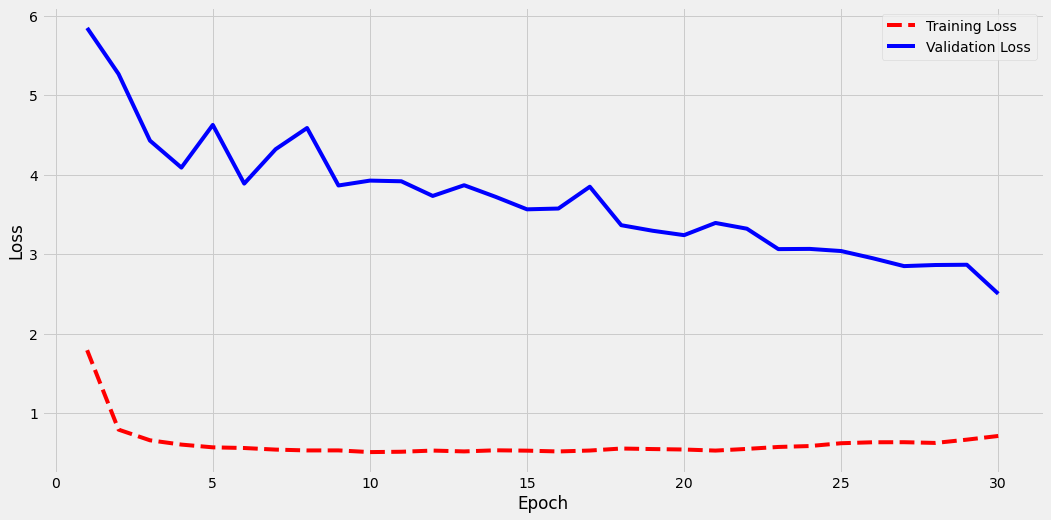

In [22]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Prediction

In [23]:
pred = model.predict(test_dataset, verbose=1)

96/96 [==============================] - 289s 3s/step


In [24]:
np.savetxt('efficientnet4b_30_ns_k0.txt', pred.numpy(), fmt='%f')

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [25]:
# drop existing feature
test_df = test_df.drop('category', axis=1)

# change with prediction
test_df['category'] = pred.argmax(axis=1)

# then add zero-padding
test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

## Make a submission

In [26]:
test_df.to_csv('submission.csv', index=False)

In [27]:
test_df.head()

filename category
0  fd663cf2b6e1d7b02938c6aaae0a32d2.jpg       41
1  c7fd77508a8c355eaab0d4e10efd6b15.jpg       27
2  127f3e6d6e3491b2459812353f33a913.jpg       29
3  5ca4f2da11eda083064e6c36f37eeb81.jpg       40
4  46d681a542f2c71be017eef6aae23313.jpg       39